In [2]:
import pandas as pd
import numpy as np
import math
import string
import copy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings("ignore")

In [42]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [43]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [44]:
test_folds = {}

In [45]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
train_l = list()
val_l = list()
test_l = list()
maxlen = 25
cnt = 0
for train_index, test_index in stfold.split(data['comment'], data['label']):
    cnt += 1
    train = data.iloc[train_index]
    train_x, train_y = train['comment'], train['label']
    tmp = data.iloc[test_index]

    val, test = train_test_split(tmp, test_size=0.5, stratify=tmp['label'])    
    val_x, val_y = val['comment'], val['label']
    test_x, test_y = test['comment'], test['label']    
    
    train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
    val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)
    test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=maxlen)
    
    test_folds[cnt] = (test_x, test_y)
    embed_dim = 64  # Embedding size for each token
    num_heads = 8  # Number of attention heads
    ff_dim = 64  # Hidden layer size in feed forward network inside transformer
    vocab_size = n_word_unique + 1

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model_path = "transformer_models/{itr:04}/".format(itr=cnt)
    checkpoint_path = model_path  + "{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    !mkdir model_path
    
    model.compile(tf.keras.optimizers.Adam(lr=0.0056), "binary_crossentropy", metrics=["accuracy", 
                                                          tf.keras.metrics.AUC(name='auc')])
    
    
    #create checkpoint to save model
    #with best validation loss
    model.save_weights(checkpoint_path.format(epoch=0))

    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1,
            save_weights_only=True, save_best_only=True, mode='max')
    
    history = model.fit(
                        train_x, train_y, 
                        batch_size=32, epochs=10, 
                        validation_data=(val_x, val_y),
                        callbacks = [checkpoint]
                        )
    
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    
    train_eval = model.evaluate(train_x, train_y)
    val_eval = model.evaluate(val_x, val_y)
    test_eval = model.evaluate(test_x, test_y)
    
    test_l.append(test_eval)
    val_l.append(val_eval)
    train_l.append(train_eval)

Epoch 1/10
249/250 [============================>.] - ETA: 0s - loss: 0.4865 - accuracy: 0.7661 - auc: 0.8434
Epoch 00001: val_auc improved from -inf to 0.92715, saving model to transformer_models/0001/0001.ckpt
250/250 [==============================] - 15s 56ms/step - loss: 0.4856 - accuracy: 0.7667 - auc: 0.8438 - val_loss: 0.3338 - val_accuracy: 0.8730 - val_auc: 0.9272
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9538 - auc: 0.9893
Epoch 00002: val_auc did not improve from 0.92715
250/250 [==============================] - 13s 53ms/step - loss: 0.1264 - accuracy: 0.9538 - auc: 0.9893 - val_loss: 0.4271 - val_accuracy: 0.8490 - val_auc: 0.9052
Epoch 3/10
249/250 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9841 - auc: 0.9977
Epoch 00003: val_auc did not improve from 0.92715
250/250 [==============================] - 14s 54ms/step - loss: 0.0485 - accuracy: 0.9841 - auc: 0.9977 - val_loss: 0.4937 - val_accuracy

In [46]:
test_l = np.array(test_l)
val_l = np.array(val_l)
train_l = np.array(train_l)

print("test avg loss: ", np.mean(test_l[:, 0]), "+/-" ,np.std(test_l[:, 0]))
print("test avg acc: ", np.mean(test_l[:, 1]),  "+/-" ,np.std(test_l[:, 1]))
print("test avg auc: ", np.mean(test_l[:, 2]),  "+/-" ,np.std(test_l[:, 2]))
print('\n')


print("val avg loss: ", np.mean(val_l[:, 0]), "+/-" ,np.std(val_l[:, 0]))
print("val avg acc: ", np.mean(val_l[:, 1]),  "+/-" ,np.std(val_l[:, 1]))
print("val avg auc: ", np.mean(val_l[:, 2]),  "+/-" ,np.std(val_l[:, 2]))
print('\n')


print("train avg loss: ", np.mean(train_l[:, 0]), "+/-" ,np.std(train_l[:, 0]))
print("train avg acc: ", np.mean(train_l[:, 1]),  "+/-" ,np.std(train_l[:, 1]))
print("train avg auc: ", np.mean(train_l[:, 2]),  "+/-" ,np.std(train_l[:, 2]))

test avg loss:  0.33307995200157164 +/- 0.055080099952948644
test avg acc:  0.875600004196167 +/- 0.019986012993357248
test avg auc:  0.9353846073150635 +/- 0.006703173759728353


val avg loss:  0.33153563141822817 +/- 0.036786808277246695
val avg acc:  0.8766000032424927 +/- 0.008522896802012923
val avg auc:  0.9354297876358032 +/- 0.009797463285738198


train avg loss:  0.1364382289350033 +/- 0.04330184694881527
train avg acc:  0.9504499912261963 +/- 0.01604906064639812
train avg auc:  0.993152403831482 +/- 0.0029975613443230346


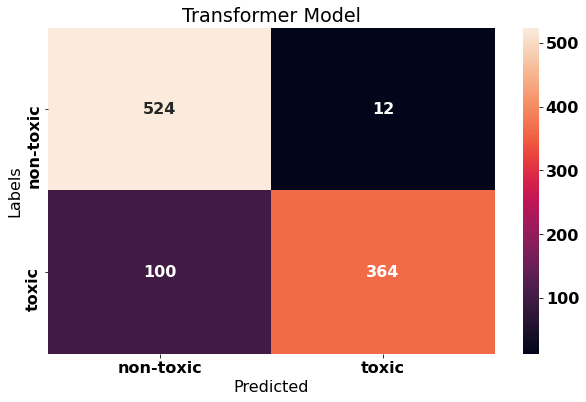

In [47]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
pred = np.array([model.predict(test_folds[5][0]) > 0.5], dtype=int).ravel()
cm = confusion_matrix(test_folds[5][1].values, pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10, 6))

sns.heatmap(cm,
            fmt = 'd',
            annot=True)


ax = plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('Labels')
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.set_title('Transformer Model')
plt.show()

In [48]:
plt.savefig('transformer.png')

<Figure size 432x288 with 0 Axes>

In [49]:
ind = np.arange(test.shape[0])
test['word_count'] = test['comment'].apply(lambda a: len(a))
test = test.reset_index(drop=True)
correct = pred==test_y
select_cor = ind[correct]
where_0_c = ind[(correct) & (test_y==0)]
where_0_n = ind[(correct==False) & (test_y==0)]
where_1_c = ind[(correct) & (test_y==1)]
where_1_n = ind[(correct==False) & (test_y==1)]

cor_mean = test.iloc[select_cor]['word_count'].mean(), 
inc_mean = test.iloc[list(set(ind) - set(select_cor))]['word_count'].mean()
cor_std = test.iloc[select_cor]['word_count'].std(), 
inc_std = test.iloc[list(set(ind) - set(select_cor))]['word_count'].std()
print("correct", cor_mean[0], '+/-', cor_std[0])
print("incorrect", inc_mean, '+/-', inc_std)
print('###########################')

cor_mean_0 = test.iloc[where_0_c]['word_count'].mean(), 
inc_mean_0 = test.iloc[where_0_n]['word_count'].mean()
cor_std_0 = test.iloc[where_0_c]['word_count'].std(), 
inc_std_0 = test.iloc[where_0_n]['word_count'].std()
print("correct 0", cor_mean_0[0], '+/-', cor_std_0[0])
print("incorrect 0", inc_mean_0, '+/-', inc_std_0)
print('###########################')


cor_mean_1 = test.iloc[where_1_c]['word_count'].mean(), 
inc_mean_1 = test.iloc[where_1_n]['word_count'].mean()
cor_std_1 = test.iloc[where_1_c]['word_count'].std(), 
inc_std_1 = test.iloc[where_1_n]['word_count'].std()
print("correct 1", cor_mean_1[0], '+/-', cor_std_1[0])
print("incorrect 1", inc_mean_1, '+/-', inc_std_1)

correct 11.844594594594595 +/- 10.223133682642697
incorrect 18.75 +/- 21.96660036354127
###########################
correct 0 11.458015267175572 +/- 11.578650850506332
incorrect 0 25.083333333333332 +/- 35.093273982173265
###########################
correct 1 12.401098901098901 +/- 7.854643581113972
incorrect 1 17.99 +/- 19.968406865027383


In [50]:
correct_list = list()
incorrect_list = list()
cor_ind = ind[correct]
incor_ind = ind[list(set(ind) - set(select_cor))]
for cor_com in test.iloc[cor_ind].comment:
    correct_list.extend(cor_com)

for incor_com in test.iloc[incor_ind].comment:
    incorrect_list.extend(incor_com)

cor_top10 = Counter(correct_list).most_common(10)
incor_top10 = Counter(incorrect_list).most_common(10)

In [52]:
ix_to_word = {v:k for k,v in word_dict_inx.items()}

In [53]:
print('CORRECT')
for cor in cor_top10:
    print(ix_to_word[cor[0]])
print('###################')
print('INCORRECT')

for incor in incor_top10:
    print(ix_to_word[incor[0]])

CORRECT
არ
რა
ეს
ჩვენი
უნდა
არე
ამ
იყო
ვერ
ერთი
###################
INCORRECT
არ
უნდა
ამ
ეს
იყო
რა
არა
საქართველო
ის
ჩვენი
